### **1. Monitoring ML Models in Production**
Models are trained and initially evaluated against historical data (some unseen reference labelled data, e.g., test data). This means that users can know that a model would have worked well in the past.

But once you deploy the model and use it to make predictions on new data, it’s often hard to ensure that it’s still working correctly. Models can degrade over time because the world is always changing. Moreover, there can be breakages or bugs in a production model’s data sources or data pipelines. In both cases, monitoring of (and alerting on) predictions made by models in production is critical.

With the increasing adoption of machine learning (ML) models and systems in high-stakes settings across different industries, guaranteeing a model’s performance after deployment has become crucial. Monitoring models in production is a critical aspect of ensuring their continued performance and reliability.

### **2. System Dynamics Invalidates Its (ML) Model**
ML Models expects that each feature data samples (training-batch, validation-batch, test-batch, or unseen-input-batch) are generated from IID (Independent and Identically Distributed). Practically, the underlying mechanism that generates some feature data must be same for all the samples (training-batch, validation-batch, etc.). This assumption must hold good for all features involved in any given Machine Learning problem.

Independent (‘I’ of IID) means that training-batch and validation-batch for any feature are not dependent. Identically Distributed (‘ID’ of IID) means that training-batch and validation batch for any feature come from same statistical distribution (i.e., same system or same mechanism that generates the feature data). This IID assumption must be valid for all features.

> _ML Model loses its predictive performance when probability distribution of any *relevant* input feature or output or both changes (which means that system variables undergo change, i.e., IID assumption violation) -or- relationship between relevant input features and output changes (i.e., the underlying system itself changes)._

### **3. ML Model Monitoring alternatives**
YouTube session in which Thomas Viehmann [ref. 18] gives a precise summary of practical alternatives in ‘’TorchDrift Presentation” section.

GCP course material in Coursera [[ref. 1]](https://www.coursera.org/lecture/gcp-production-ml-systems/concept-drift-kcTDO) lists the following ways (refer pic below) in which ML systems can drift.

<center> <p>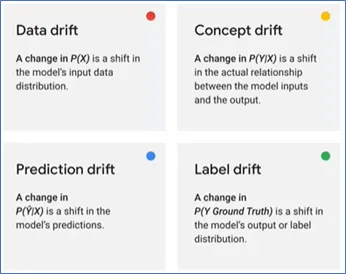</p> </center>

Here is further elaborate depiction of Model Monitoring alternatives and how input and output are involved (refer pic below).

<center> <p>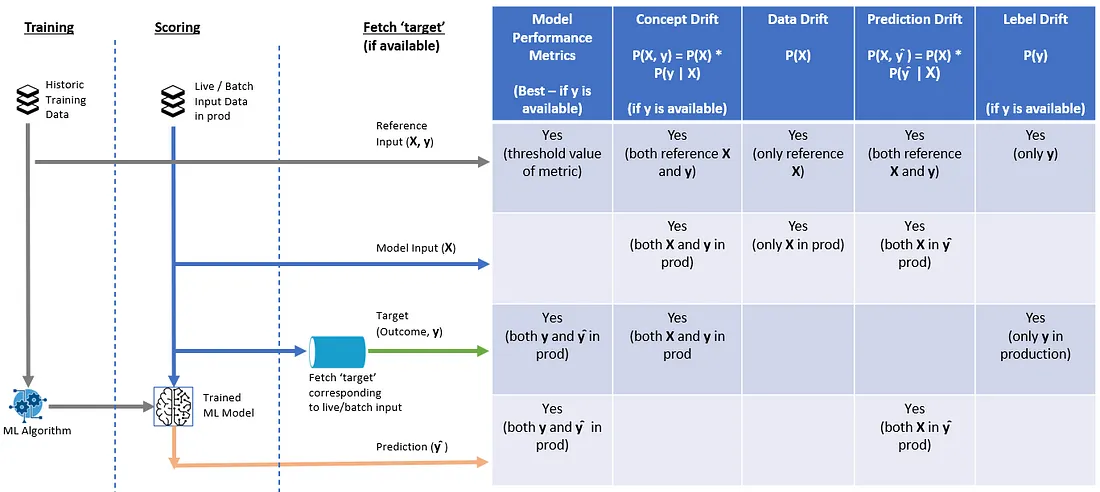</p> </center>

#### **3.1. Model Performance Metrics Monitoring**
If ‘target’ is asynchronously available corresponding to live/batch ‘model input’ in production, aka ‘delayed ground truth’ — like ‘actual time arrival’ corresponding to ‘expected time arrival’ in any taxi trip ML problem scenario — then it is best to explicitly monitor Model Performance Metrics in production. Intuitively, they must be the same Metrics used during Model Evaluation.
> *It is the most impactful model monitoring approach if ‘delayed ground truth’ is available in production.*

#### **3.2. Data Drift**
It is defined as the drift in distribution of probability $P(X)$ in production with respect to that of some reference (say training input or even early/trusted batch of model input data in production).

Note that Data Drift must be separately estimated for each feature, i.e., univariate drift. One intuitive way of estimating Overall Data Drift for features altogether could be through weighted mean of individual Feature Data Drift with Features Importance as their weight — but note that even Features Importance is a moving part!

> _This is the most prevalent practical approach as X (model input in production) is the first thing which can be easily captured for model monitoring._

Other alternatives have critical dependency on $y$ (‘delayed ground truth’ in production) or $\hat y$ (‘prediction’ in production — which is after all the output corresponding to input $X$).
> *Note that feature space of tabular input data can be treated separately through univariate data drift but multi-dimensional input feeding Deep Learning for Computer Vision (CV) or Natural Language Processing (NLP) may not be treated individually. Data Drift in Deep Learning for CV/NLP requires dimensionality reduction and then multivariate drift detection [[ref 2]](https://arxiv.org/pdf/1810.11953.pdf).*

#### **3.3. Concept Drift**
Note that this approach of Model Monitoring requires ‘delayed ground truth’ in production. It measures the relationship between ‘model input’ and ‘target’ production data in the form of joint probability distribution or conditional probability distribution. It is the drift of the probability distribution with respect to some reference (say training input and target).

Refer to below probabilistic explanation of Concept Drift from [[ref. 1]](https://www.coursera.org/lecture/gcp-production-ml-systems/concept-drift-kcTDO). Observe in the pic below that Concept Drift is a combined effect of drifts in both data-alone (Data Drift) or relationship-alone or both.

<center> <p>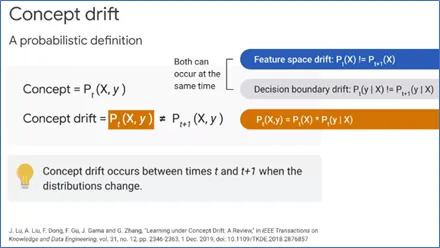</p> </center>

#### **3.4. Prediction Drift**
It is defined as drift in distribution of conditional probability $P(\hat y | X)$ of production data with respect to that of some reference (say training input and target).

> *Note that Data Drift, i.e., drift in distribution of $P(X)$ may be enough to measure ML Model Drift as $\hat y$ is after all the output corresponding to input X and hence Prediction Drift may not yield any additional value beyond Data Drift.*

#### **3.5. Label Drift**
It is defined as drift in distribution of $P(y)$ with respect to that of some reference (say training target probability distribution).

> *If ‘delayed ground truth’ in production is available, then this Label Drift alone can be enough to warn of impending invalidation of ML Model.*

#### **3.6. Bias Drift**
This measure has been observed in the context of AWS Sagemaker Model Monitor service [[ref. 3]](https://arxiv.org/pdf/2111.13657.pdf).

Pre-training Bias Drift (somewhat like Data Drift) is calculated by splitting training data it into two parts corresponding to suspicious feature (say ‘Sex’ or ‘Age below/above some threshold’). These two parts of the training data are statistically compared by various measures (KL-divergence, JS-Divergence, KS-Test, etc.).

Post-training Bias Drift (somewhat like Model Performance Metrics Drift) appears to be difference in predictive metrics of Production Data parts corresponding to suspicious feature.

#### **3.7. Features Attribution Drift (though it is slightly about Model Explainability)**
This is essentially a change in feature importance between training and production. For the feature importance to be meaningful in production, we must have the ‘delayed ground truth’ available. This measure is support in AWS Sagemaker Model Monitor and GCP Vertex AI Drift Monitoring.

#### **3.7. Data Quality**
Assuming that the production environment does not change from data dimensions perspective — Data Quality/Schema Drift [[ref. 20]](https://ckaestne.medium.com/data-quality-for-building-production-ml-systems-2e0cc7e6113f) should be mostly an engineering problem of Data Governance before data from source(s) land into ML Data Store.

Even Model Monitoring systems cover Data Quality aspects which may appear like proactive overlap.

### **4. Model Monitoring Mathematics**
The above explanations about alternatives and formulae [in sec. 3] suggests that the only entity which requires some insights is how to compute probability distribution and then measure drift in probability distributions.

#### **4.1. Probability Distribution — Most Important Ingredient for any Drift computation**
The most popular form of Density Estimation, i.e., Probability Density is Histogram. But then, KDE (Kernel Density Estimation) [[ref. 4]](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/) is more efficient continuous curve approximation where kernel could be Gaussian, Linear, Cosine, Exponential, etc. The KDE algorithm takes a parameter, bandwidth, that affects how “smooth” the resulting curve is.

Sample visualization of Probability Distribution of training-batch and test-batch of ‘Age’ feature from ‘Titanic’ dataset: -

Text(0.5, 1.0, 'Test set')

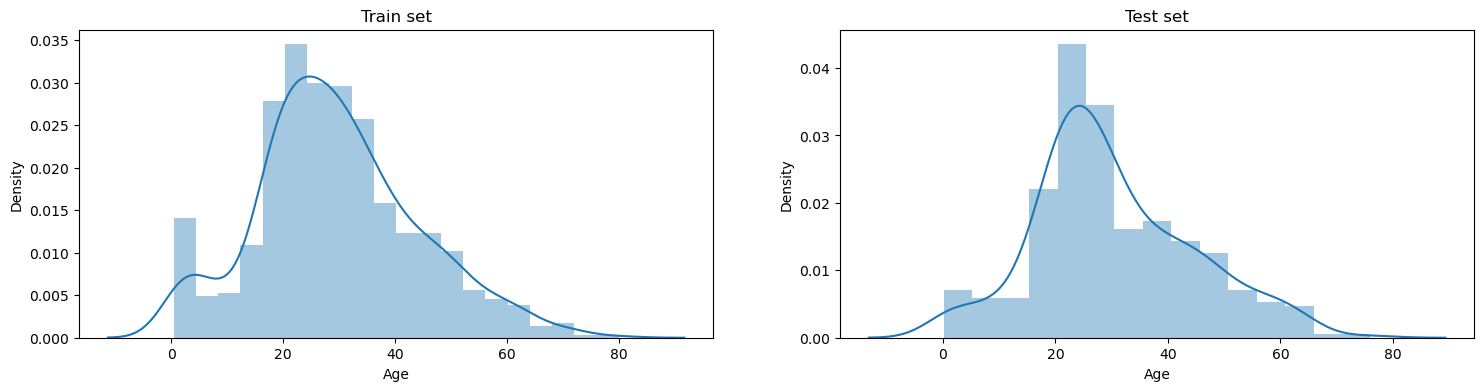

In [1]:
######################################
# Histogram vs PDF visualization
######################################

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(df_train['Age'].dropna(), ax=ax1)
ax1.set_title('Train set')

sns.distplot(df_test['Age'].dropna(), ax=ax2)
ax2.set_title('Test set')

Sample computation of Probability Distribution using `scipy.stats.gaussian_kdeon` 3 data samples of normal distribution with varying mean — and corresponding visualization of data samples and their estimated Probability Distributions: -

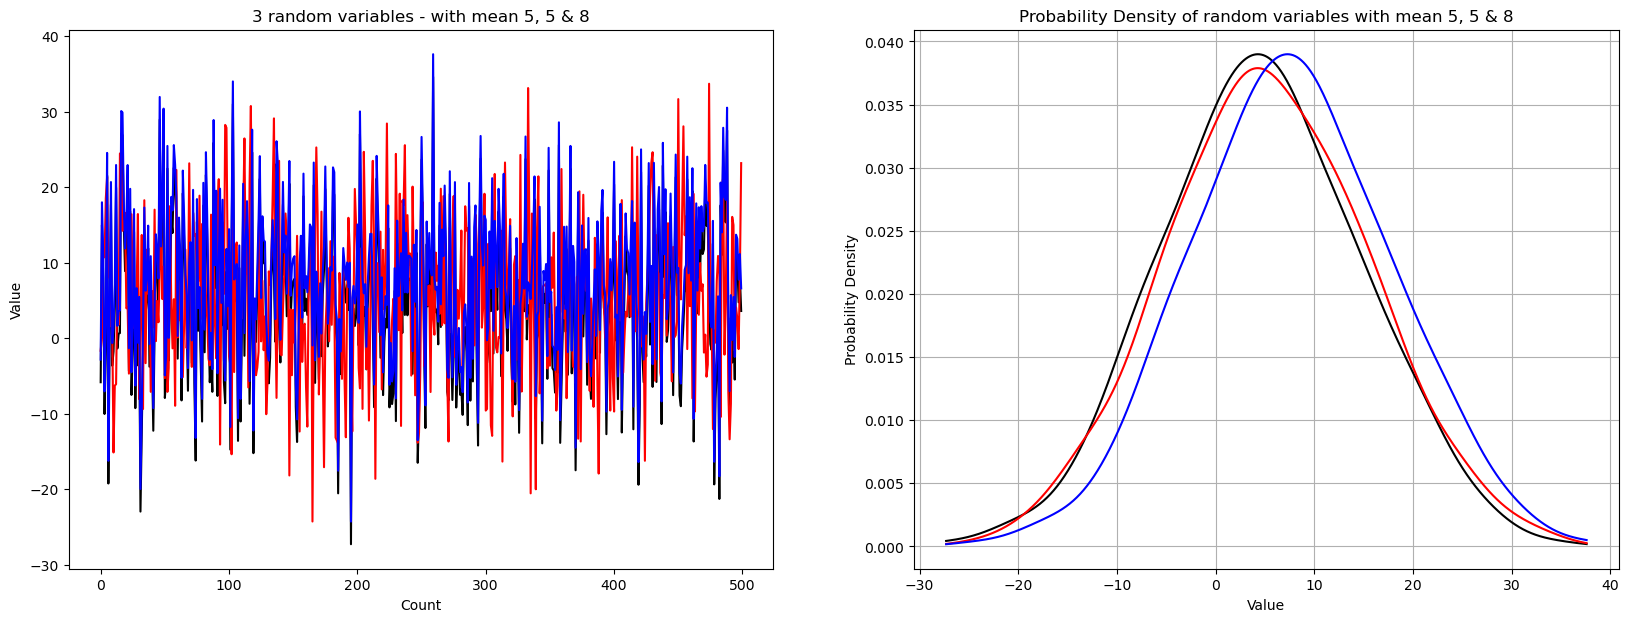

In [2]:
######################################
# Probability Density Function (pdf)
######################################

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(1234)

fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(121)
ax1.set_title('3 random variables - with mean 5, 5 & 8')
ax1.set(xlabel='Count', ylabel='Value')
rvs1 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=123)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=456)
rvs3 = stats.norm.rvs(loc=8, scale=10, size=500, random_state=123)
ax1.plot(rvs1, 'k-')
ax1.plot(rvs2, 'r-')
ax1.plot(rvs3, 'b-')

ax2 = fig.add_subplot(122)
ax2.set_title('Probability Density of random variables with mean 5, 5 & 8')
ax2.set(xlabel='Value', ylabel='Probability Density')
kde1 = stats.gaussian_kde(rvs1)
kde2 = stats.gaussian_kde(rvs2)
kde3 = stats.gaussian_kde(rvs3)
max_all_rvs = max(max(rvs1), max(rvs2), max(rvs3))
min_all_rvs = min(min(rvs1), min(rvs2), min(rvs3))
x_eval_common = np.linspace(max_all_rvs, min_all_rvs, num=10000)
ax2.plot(x_eval_common, kde1(x_eval_common), 'k-')
ax2.plot(x_eval_common, kde2(x_eval_common), 'r-')
ax2.plot(x_eval_common, kde3(x_eval_common), 'b-')

plt.grid()

#### **4.2 Data Drift based on Statistics Entropy Difference or Distance**
> *These statistical measure of entropy difference or distance between probability distribution need to be compared against some threshold value for tagging such drift as significant.*

Observe these below code snippets based on first principal and compare with code from [[ref. 5]](https://github.com/zpincus/zplib/blob/master/zplib/scalar_stats/compare_distributions.py) or from EvidentlyAI [[ref. 6]](https://github.com/evidentlyai/evidently/tree/main/src/evidently/analyzers/stattests).

#### **4.2.1. Univariate Testing — Kullback-Leibler (KL) Divergence**

Kullback-Leibler Divergence (also called relative entropy) is a way of comparing probability distributions of same feature (‘original distribution of some feature’ from some reference data like Training Data with the ‘approximating distribution of same feature’ from Model Input Data in Production).

$$
    \mathcal D_{KL}(p||q) = \sum_{i=1}^N p(x_i) (\log p(x_i) - \log q(x_i))
$$

<center> <p>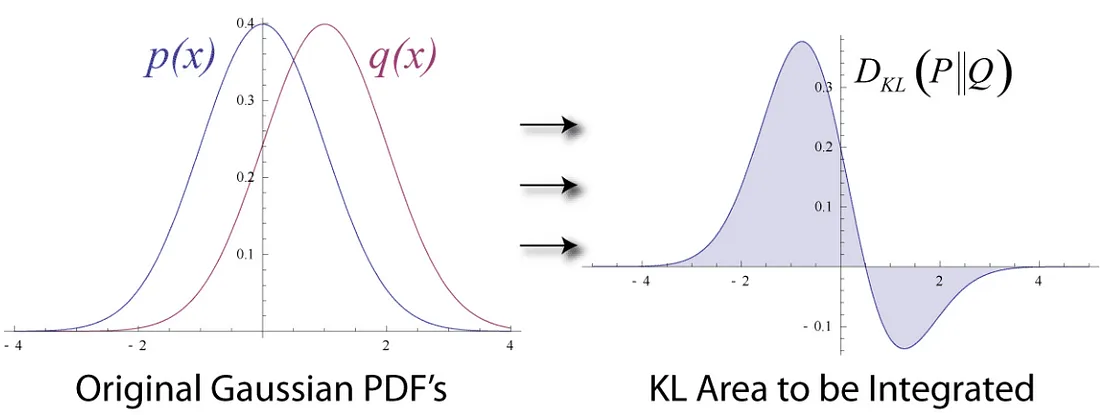</p> </center>

Sample estimation of KL-Divergence between above simulated data samples — KL-Divergence is very low (-0.0026) when data samples (rvs1 & rvs2) come from same distribution vs relatively high value (-0.04) when data samples (rvs1 & rvs3) come from different distributions: -

In [3]:
######################################
# KL-Divergence function
######################################

def kl_divergence(pd_featureX_train, pd_featureX_test, featureX_linspace):
    # Calculate Kullback-Leibler divergence of pd1 and pd2
    # pd_featureX_train: Probability Density of featureX from training batch
    # pd_featureX_test: Probability Density of featureX from test batch
    # featureX_linspace: numpy.linspace resampled values corresponding to 
    #                    min/max of union of both train and test batch of featureX

    kl = pd_featureX_train * (np.log(pd_featureX_train) - np.log(pd_featureX_test))
    kl[~np.isfinite(kl)] = 0 # small pd value can cause NaN/-inf

    return np.trapz(kl, x=featureX_linspace) #integrate curve

######################################
# KL-Divergence between RVS1 and RVS2
# Note that mean(RVS1) == mean(RVS2)
######################################

pd_train = kde1(x_eval_common)
pd_test = kde2(x_eval_common)
print(kl_divergence(pd_train, pd_test, x_eval_common))

######################################
# KL-Divergence between RVS1 and RVS3
# Note that mean(RVS1) != mean(RVS3)
######################################

pd_train = kde1(x_eval_common)
pd_test = kde3(x_eval_common)
print(kl_divergence(pd_train, pd_test, x_eval_common))


-0.0026415243730632887
-0.040995533551870675


#### **4.2.2. Multiple Univariate Testing — Jensen-Shannon (JS) Divergence**

JS Divergence is just a symmetric version of KL Divergence.

$$
    JSD(P||Q) = \frac{1} {2} D_{KL}(P||Q) + \frac{1} {2} D_{KL}(Q||M) \\
    \text {where } M = \frac {1} {2} (P+Q) \text{ and } D_{KL} \text { is the KL divergence.}
$$


Observe that JS-Divergence estimation through first principal based calculation as well as by `scipy.spatial.distance.jensenshannonare` almost same!

In [5]:
########################################
# JSD as per first principal calculation
########################################

def js_divergence_raw(pd_featureX_train, pd_featureX_test, featureX_linspace):
    P = np.array(pd_featureX_train)
    Q = np.array(pd_featureX_test)
    M = 0.5 * (P + Q)

    return 0.5 * (
        kl_divergence(P, M, featureX_linspace) +
        kl_divergence(Q, M, featureX_linspace))

pdf1 = kde1(x_eval_common)
pdf2 = kde2(x_eval_common)
pdf3 = kde3(x_eval_common)

js_div_12 = js_divergence_raw(pdf1, pdf2, x_eval_common) # JS-Divergence between RVS1 and RVS2
js_div_13 = js_divergence_raw(pdf1, pdf3, x_eval_common) # JS-Divergence between RVS1 and RVS3
print((js_div_12, js_div_13))

#########################################
# JSD using Scipy
#########################################
from scipy.spatial import distance

js_distance_12 = distance.jensenshannon(pdf1, pdf2)
js_div_12 = js_distance_12**2

js_distance_13 = distance.jensenshannon(pdf1, pdf3)
js_div_13 = js_distance_13**2

print((js_div_12, js_div_13))

(-0.0008786921324974282, -0.010119710819173608)
(0.000879700231145514, 0.010136023781807908)


#### **4.2.3. Multiple Univariate as well as Multivariate Testing — Wasserstein Distance**

Wasserstein Distance is another measure of difference in Probability Distributions. The First Wasserstein distance (WD1) [[ref. 7]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) between the distributions $u$ and $v$ and their corresponding cumulative distributions $U$ and $V$ is

$$
    l_1 (u, v) = \int_{-\infty}^{\infty} |U - V|
$$

Wasserstein Distance appears to be inspired or related to Optimal Transport [[ref. 19]](https://www.researchgate.net/publication/324246144_Sliced-Wasserstein_Autoencoder_An_Embarrassingly_Simple_Generative_Model) Problem of moving earth/dirt/rubble from one pile to another (Earth Mover Distance) — they are equivalent: a) when transport cost is replaced by difference in CDF and b) when assumption of dirt content being same is matched by same total probability under both distributions. Below pic [ref. 8] shows quite intuitive interpretation of First Wasserstein Distance (WD1).

<center> <p>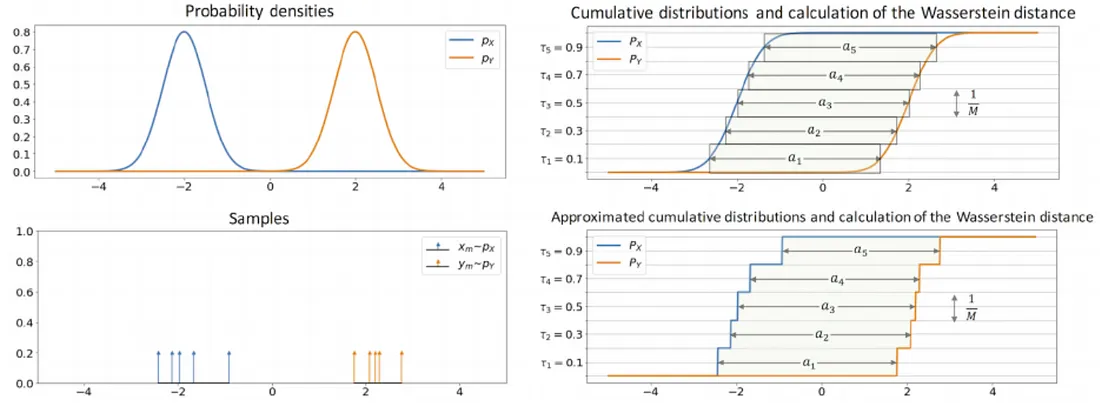</p> </center>

Though `scipy.stats.wasserstein_distance` is meant for First Wasserstein Distance between univariate distributions, Wasserstein Distance is generic enough for multivariate feature space. Generic WD can be used for multivariate tabular as well as for multivariate feature space present in Computer Vision and NLP.

#### **4.2.4. Multiple Univariate (Categorical) Testing: L-Infinity Distance**

L-Infinity [[ref. 9]](https://en.wikipedia.org/wiki/Chebyshev_distance) is actually the infinity-norm between pair of vectors. In our context of Data Drift, these vectors are frequency distribution of categorical feature (say ‘Passenger Class’ categorical feature of ‘Titanic’ dataset from training-batch and test-batch). L-Infinity Distance turns out to be max absolute difference in probability distribution.

$$
    || \vec{x} - \vec{y} ||_{\infty} = \lim\limits_{p \to \infty} \sqrt[p]{|x_1 - y_1|^p + \ldots + |x_D - y_D|^p} \\
    = \max\limits_{1 \leq d \leq D} |x_d - y_d|
$$

#### **4.3. Data Drift based on Statistical Hypothesis Testing**

> *Similarly, even Statistical Hypothesis Testing measures of distribution difference need to be compared against some threshold (critical value of test statistic or p-value) for tagging such drift as significant.*

Null Hypothesis (H0) that given sample distributions are not-significantly-different can be accepted in favor of H(0) or rejected in favor of Alternate Hypothesis H(a) that sample distributions are significantly-different — as per Critical Value Approach [[ref. 10]](https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing/critical-value-approach) where observed test statistic is checked against some well defined critical value or P-value Approach [[ref. 11]](https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing/p-value-approach) where observed p-value is compared against significance level (α).

#### **4.3.1. Multiple Univariate Testing — Kolmogorov-Smirnov (KS) Test**

KS-Test is a nonparametric test of the equality of probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). In essence, the test answers the question “What is the probability that this collection of samples could have been drawn from that probability distribution?” or, in the second case, “What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?” [[ref. 12]](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

<center> <p>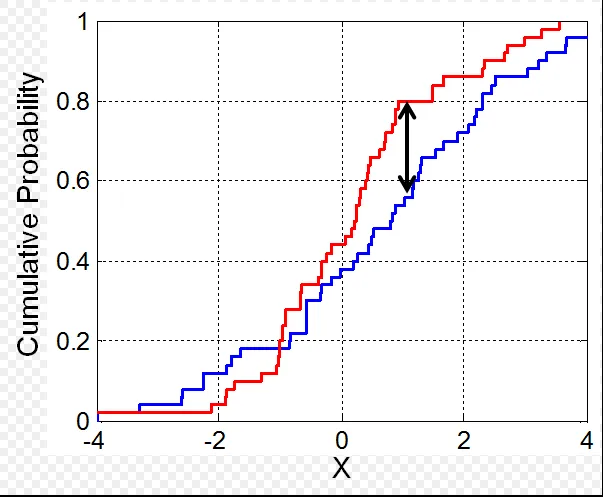</p> </center>

#### **4.3.2. Multiple Univariate (Categorical) Testing — Chi-Square Goodness-of-Fit Test**

The Chi-square Goodness-of-Fit Test `scipy.stats.chisquare` is a statistical hypothesis test used to determine whether a (categorical) variable is likely to come from a specified distribution or not. The test statistic as per below formula is calculated from observed and expected frequencies and it is tested for Critical Value (Chi-Square distribution, degree of freedom, confidence level) [[ref. 13]](https://web.archive.org/web/20171022032306/http:/vassarstats.net:80/textbook/ch8pt1.html).

$$
    \chi^2 = \sum \frac {(O - E)^2} {E}
$$

<center> <p>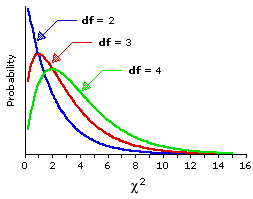</p> </center>

In the context of Data Drift, this test is useful in measuring drift of categorical feature — say ‘Passenger Class’ categorical feature of ‘Titanic’ dataset from training-batch and test-batch can be evaluated for drift.

When analysis of categorical data is concerned with more than one variable (say a categorical input feature and categorical output target), two-way tables (also known as contingency tables) are employed. These tables provide a foundation for statistical inference, where statistical tests question the relationship between the variables on the basis of the data observed. The Chi-square test `scipy.stats.chi2_contingency` provides a method for testing the association between the row and column variables in a two-way table — which may be useful to check if a categorical input feature is important or relevant to categorical output target.

#### **4.3.3. Multivariate Kernel Two-Sample Tests: Maximum Mean Discrepancy (MMD)**

For all multidimensional representations, the Maximum Mean Discrepancy is a popular kernel based technique for multivariate two-sample testing. This algorithm can be used for multivariate tabular as well as for multivariate feature space present in Computer Vision and NLP.

### **5. Model Monitoring Practices**
#### **5.1. Uber Michelangelo Machine Learning Platform**
Refer to Scaling Machine Learning at Uber with Michelangelo >> Monitor Data and Predictions section in [[ref. 14]](https://eng.uber.com/scaling-michelangelo/).

We have two approaches to monitoring models in production.

1. The *most accurate approach* is to log predictions (say expected time arrival ETA) made in production and then join these to the outcomes (say actual time arrival) as they are collected by our data pipelines; by comparing predictions against actuals, we can compute precise accuracy metrics. This is same as *Model Performance Metrics Monitoring*.

2. In cases where the outcomes are not easily collected or where we cannot easily join the predictions to outcomes, a *second approach* is to monitor the distributions of the features and predictions and compare them over time. This is a less precise approach but can still often detect problematic shifts in features and corresponding predictions. This is same as *Data Drift and Prediction Drift Monitoring*.

#### **5.2. Azure Machine Learning Platform — Datasets Monitoring**

All resources involved in Azure Machine Learning are encapsulated inside so-called Azure Machine Learning Workspace. It is a centralized place to work with all the artifacts one creates while using Azure Machine Learning.

<center> <p>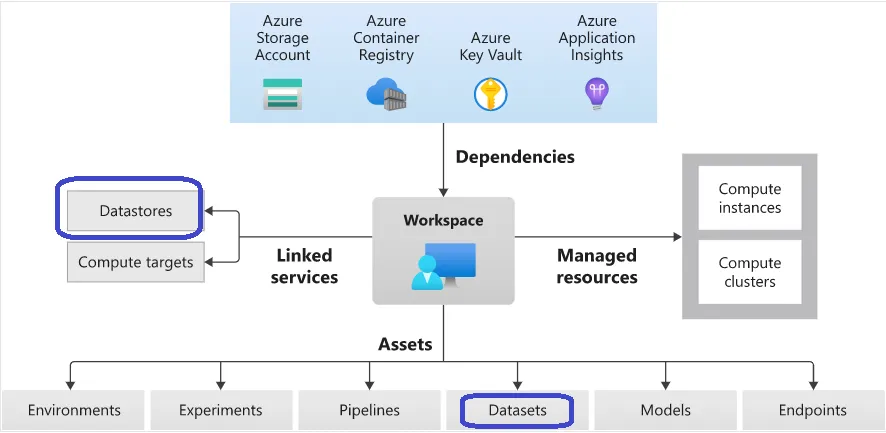</p> </center>

> It is just the Datasets in Azure ML Workspace which are involved in scheduled Data Drift Monitoring on managed Azure ML Compute. Azure ML supports Data Drift Monitoring through its `azureml.datadrift.DataDriftDetector` construct which monitors so called `target_dataset` with respect to `baseline_dataset`. Note that Azure ML terminology `target_dataset` is for ML Model Input Data in Production.

<center> <p>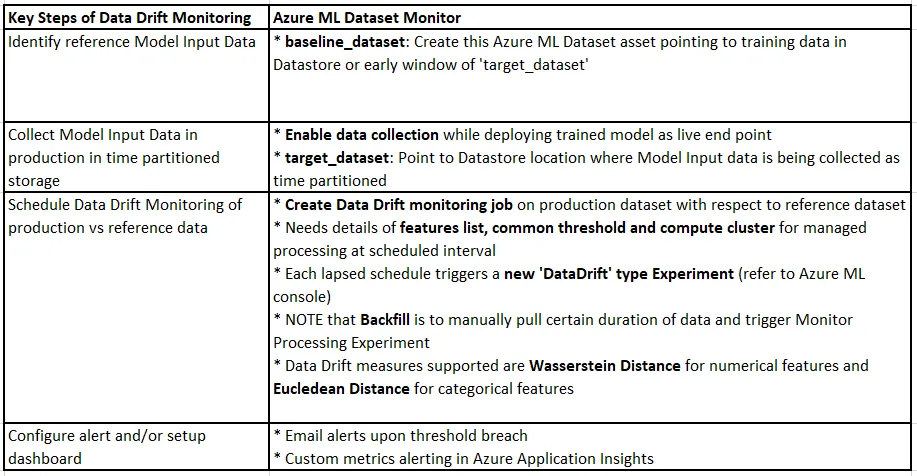</p> </center>

Below code snippet is from [[ref. 15]](https://github.com/MicrosoftLearning/mslearn-dp100/blob/main/17%20-%20Monitor%20Data%20Drift.ipynb).

```python
########################################
# Create baseline_dataset
########################################
baseline_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds,
                        'diabetes-baseline/*.csv'))

baseline_data_set = baseline_data_set.register(workspace=ws, 
                        name='diabetes baseline',
                        description='diabetes baseline data',
                        tags = {'format':'CSV'},
                        create_new_version=True)


########################################
# Create target_dataset
########################################
# Use the folder partition format to define a dataset 
# with a 'date' timestamp column
partition_format = path_on_datastore + '/diabetes_{date:yyyy-MM-dd}.csv'

target_data_set = Dataset.Tabular.from_delimited_files(
                        path=(default_ds, path_on_datastore + '/*.csv'),
                        partition_format=partition_format)

# Register the target dataset
target_data_set = target_data_set.with_timestamp_columns('date').register(workspace=ws,
                        name='diabetes target',
                        description='diabetes target data',
                        tags = {'format':'CSV'},
                        create_new_version=True)


########################################
# Create Model Monitoring Schedule
########################################

from azureml.datadrift import DataDriftDetecto

# set up feature list
features = ['Pregnancies', 'Age', 'BMI']

# set up data drift detector
monitor = DataDriftDetector.create_from_datasets(ws, 'mslearn-diabates-drift',    
                                    baseline_data_set, target_data_set,
                                    compute_target=cluster_name, 
                                    frequency='Week', 
                                    feature_list=features, 
                                    drift_threshold=.3, 
                                    latency=24)
```

The `baseline_dataset` could either be the training dataset corresponding to the deployed model or some trusted/early batch of `target_dataset`.

The `target_dataset` should be setup by pointing to the Datastore location where Model Input data is being collected over time either through Live Inference Data Collection (refer how to enable data collection in [[ref. 16]](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-enable-data-collection)) or through scheduled Batch Inference (refer to Input Dataset in batch inference pipeline sample in [[ref. 17]](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/parallel-run/tabular-dataset-inference-iris.ipynb)).

Though obvious that any monitoring would operate on temporal data, even Model Monitoring expects model input and/or output data to be collected in time partitioned storage.

> *Model Input Data collection can be enabled on Azure ML Model Deployed in AKS — which collects data in time partitioned storage (below is an example of sample data path of Model Input Data in production):*


Azure ML Data Drift Monitoring result is available in Azure ML Workspace >> Data >> Dataset Monitor (refer below pic)

<center> <p>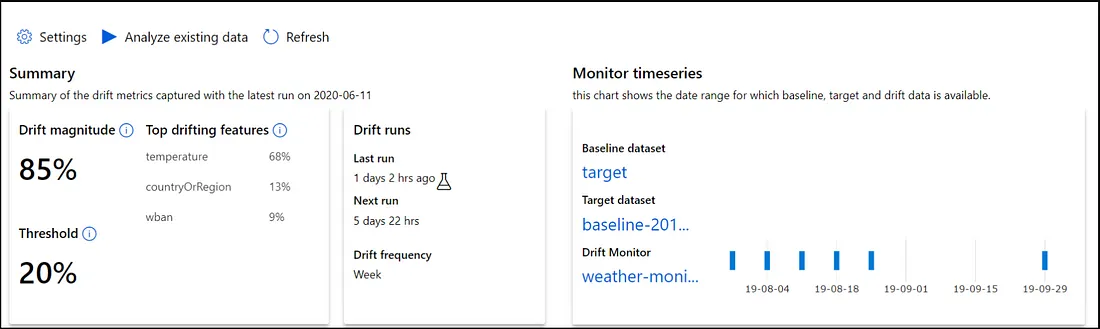</p> </center>

#### **5.3. AWS Sagemaker — Model Monitoring Service**
Amazon SageMaker Model Monitor continuously monitors the quality of Amazon SageMaker machine learning models in production. With Model Monitor, you can set alerts that notify you when there are deviations in the model quality. You can use Model Monitor prebuilt monitoring capabilities that do not require coding. You also have the flexibility to monitor models by coding to provide custom analysis.

<center> <p>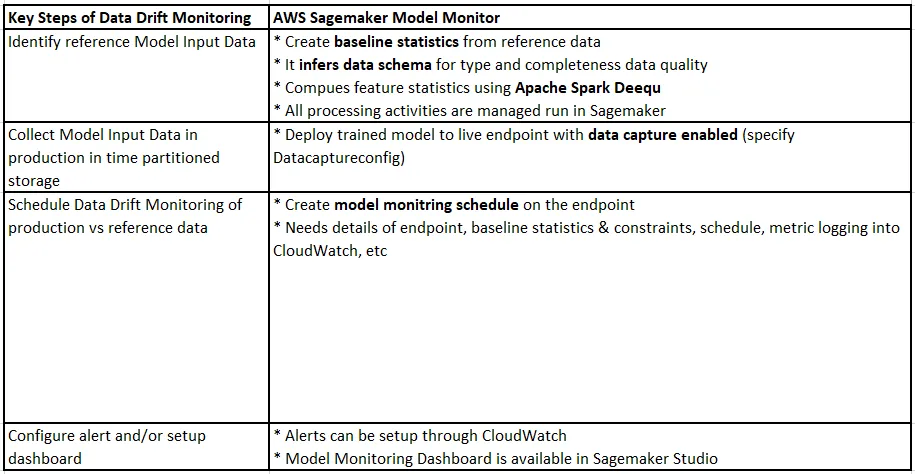</p> </center>

<center> <p>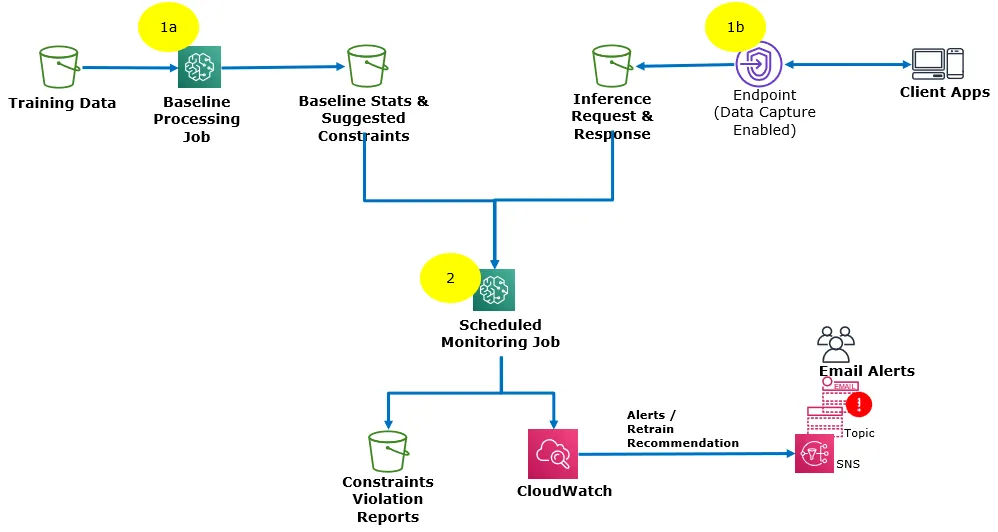</p> </center>

Sagemaker Model Monitor provides the following types of monitoring:

- Data Quality Drift
- Model Performance Metrics Monitoring
- Data Drift
- Bias Drift (Pre-training Bias Drift as Data Drift between parts of Training Data itself; Post-training Bias Drift as Model Performance Metric Drift between parts of Production Data itself)
- Feature Attribution Drift in Production (though this is a topic about Explainability)+

#### **5.4. GCP Vertex AI**
Vertex AI Model Monitoring supports feature skew (with respect to Training Data) and drift (successive window of Model Input Data itself in Production) detection for categorical and numerical input features in Production.

When a model is deployed in production with Model Monitoring enabled, incoming prediction requests are logged in a BigQuery table in your Google Cloud project. The input feature values contained in the logged requests are then analyzed for skew or drift.

<center> <p>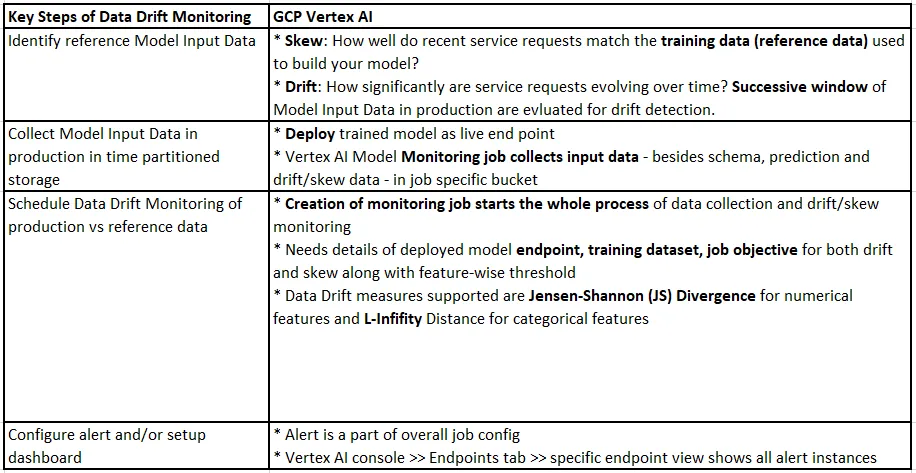</p> </center>

```python
######################################
# GCP Vertex AI Model Monitoring Job
######################################

training_dataset = ModelMonitoringObjectiveConfig.
    TrainingDataset(target_field=TARGET)
training_dataset.bigquery_source = BigQuerySource(input_uri=DATASET_BQ_URI)

objective_config = ModelMonitoringObjectiveConfig(
    training_dataset=training_dataset,
    training_prediction_skew_detection_config=skew_config,
    prediction_drift_detection_config=drift_config,
    explanation_config=explanation_config,
)

model_ids = get_deployed_model_ids(ENDPOINT_ID)

objective_template = ModelDeploymentMonitoringObjectiveConfig(
    objective_config=objective_config
)

objective_configs = set_objectives(model_ids, objective_template)

monitoring_job = create_monitoring_job(objective_configs))
```

### **6. Industrialized Data and AI Engineering Acceleration (IDEA) BY Capgemini**
IDEA by Capgemini [[ref. 21]](https://www.capgemini.com/solutions/industrialized-data-ai-engineering-acceleration-idea-by-capgemini/) & [[ref. 22]](https://www.linkedin.com/pulse/becoming-data-master-eric-reich/) — is a suite of capabilities, accelerators, frameworks and methodologies that help organizations modernize their data estate as it relates to people, processes and technology. IDEA by Capgemini leverages cloud technology, DevOps principles and a modular microservices architecture to reduce the burden of change on the workforce and help organizations simplify and streamline every aspect of their Data and AI modernization journey.

<center> <p>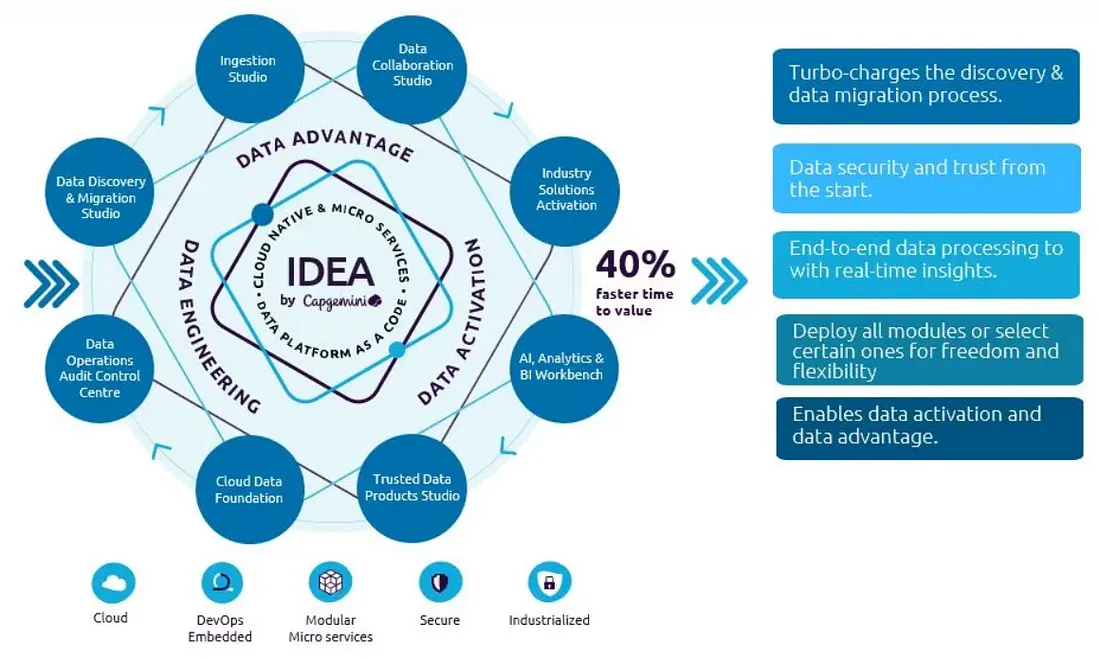</p> </center>

IDEA has Insights Foundation module for AI acceleration on Cloud ML platforms for all phases of ML lifecycle — including Model Monitoring.

> *Author leads this AI/ML workstream of IDEA accelerators platform at Capgemini.*

#### **References**
1. Concept Drift video training as part of Coursera course by GCP. https://www.coursera.org/lecture/gcp-production-ml-systems/concept-drift-kcTDO
2. Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift https://arxiv.org/pdf/1810.11953.pdf
3. AWS Sagemaker Model Monitor https://arxiv.org/pdf/2111.13657.pdf
4. Kernel Density Estimation in Python https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
5. Nice collection of no frill code for comparing distributions in Python. https://github.com/zpincus/zplib/blob/master/zplib/scalar_stats/compare_distributions.py
6. EvidentlyAI open source library for Model Monitoring. https://github.com/evidentlyai/evidently/tree/main/src/evidently/analyzers/stattests
7. Scipy — Wasserstein Distance https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
8. Wasserstein Distance https://www.researchgate.net/publication/324246144_Sliced-Wasserstein_Autoencoder_An_Embarrassingly_Simple_Generative_Model
9. L-Infinity Distance https://en.wikipedia.org/wiki/Chebyshev_distance
10. Hypothesis Testing — Critical Value Approach. https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing/critical-value-approach
11. Hypothesis Testing — P-value Approach. https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing/p-value-approach
12. Kolmogorov Smirnov (KS) Test. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
13. Chi-Square chapter from Statistics book referred by Scipy documentation https://web.archive.org/web/20171022032306/http:/vassarstats.net:80/textbook/ch8pt1.html
14. Scaling Machine Learning at Uber with Michelangelo. https://eng.uber.com/scaling-michelangelo/
15. Azure ML Dataset Drift code sample https://github.com/MicrosoftLearning/mslearn-dp100/blob/main/17%20-%20Monitor%20Data%20Drift.ipynb
16. Azure ML Live Inference Data Collection https://docs.microsoft.com/en-us/azure/machine-learning/how-to-enable-data-collection
17. Azure ML Batch Pipeline https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/parallel-run/tabular-dataset-inference-iris.ipynb
18. PyTorch Community Discussion with TorchDrift Authors (YouTube session) https://www.youtube.com/watch?v=rV5BhoKILoE
19. Wasserstein Distance in the context of Autoencoder https://www.researchgate.net/publication/324246144_Sliced-Wasserstein_Autoencoder_An_Embarrassingly_Simple_Generative_Model
20. Data Quality for Production ML https://ckaestne.medium.com/data-quality-for-building-production-ml-systems-2e0cc7e6113f
21. IDEA — by Capgemini https://www.capgemini.com/solutions/industrialized-data-ai-engineering-acceleration-idea-by-capgemini/
22. Becoming a Data Master https://www.linkedin.com/pulse/becoming-data-master-eric-reich/